# BLU06 - Learning Notebook - Data wrangling workflows - Part 1 of 3

# Imports

In [1]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris

# About the data

The New York Philharmonic played its first concert on December 7, 1842.

The data documents all known concerts, amounting to more than 20,000 performances. Some considerations:
* The Program is the top-most level element in the dataset
* A Program is defined as performances in which the repertoire, conductors, and soloists are exactly the same
* A Program is associated with an Orchestra (e.g., New York Philharmonic) and a Season (e.g., 1842-43)
* A Program may have multiple Concerts with different dates, times and locations
* A Program's repertoire may contain multiple Works (e.g., two different symphonies by Beethoven)
* A Work can have multiple Soloists (e.g. Mahler on the harpsichord, Strauss or Bernstein on the piano).

**For more information about the dataset, including the data dictionary, please head to the README.**

In this unit we will be using Works and Concerts, imported (without surprise) as follows.

In [2]:
works = pd.read_csv('../data/works.csv')
concerts = pd.read_csv('../data/concerts.csv')

# About the unit 

## Data wrangling workflows

A typical data science workflow goes as follows: you get data from a source, you clean it and then you continuously iterate on it.

![data_transformation_workflow](../media/data_processing_workflow.png)

*Fig. 1 - A  typical data processing workflow.*

On the previous learning units in this specialization, we focused mostly on getting and cleaning data (the blue boxes above). 

At this point, we got a dataset and performed basic data cleaning. Our data is, therefore, at an interim state:
* You have a *tidy dataset* (observations as rows and features as columns), comprised of one or more tables
* You know how to import such tables into Pandas, regardless of the format they are stored in.

Now, in order to explore, visualize and model the data, we have to perform transformations on it with agility, balancing:
* Speed of iteration, testing different hypothesis fast and easy
* Consistency, ensuring our pipeline doesn't collapse along the way.

In this first part, we will go into how to about transforming the dataset and exploring it in Pandas.

Then, we zoom in on a how to combine dataframes.

Finally, we move to scikit-learn in order to build efficient model pipelines.

# 1 Data transformation

## 1.1 Transformations as functions

Most data transformations operate on dataframes: they receive a local dataframe, transform it and return a new one.

In its simplest form, this is the signature of a generic data transformer.

In [3]:
def data_transformer(df):
    df = df.copy()
    # df = ...
    return df

Such transformations have no side effects and operate as functions on immutable data (i.e., keep the original dataframe unchanged).

Since the output depends only on the arguments, calling them the same arguments always produces the same result.

Confusing? Not really.

In [4]:
def rename_column(df, new_name, old_name):
    df = df.copy()
    df[new_name] = df[old_name]
    df = df.drop(columns=old_name)
    return df

def test_dataframe():
    data = np.random.randn(6, 4)
    columns = ['A', 'B', 'C', 'D']
    return pd.DataFrame(data=data, columns=columns)

df = test_dataframe()

rename_column(df, 'Z', 'A')

,B,C,D,Z
0,-0.601393,-1.720659,-0.583135,0.636418
1,-0.850753,-0.489556,-0.885317,-0.687663
2,-0.490153,1.044003,-1.796372,-1.764036
3,0.882533,-0.241240,0.828810,-0.254796
4,1.465981,1.065129,-0.609126,1.200521
5,1.242778,-0.143078,-1.082163,0.767064


In [5]:
rename_column(df, 'Z', 'A')

,B,C,D,Z
0,-0.601393,-1.720659,-0.583135,0.636418
1,-0.850753,-0.489556,-0.885317,-0.687663
2,-0.490153,1.044003,-1.796372,-1.764036
3,0.882533,-0.241240,0.828810,-0.254796
4,1.465981,1.065129,-0.609126,1.200521
5,1.242778,-0.143078,-1.082163,0.767064


Same result, see! The program (or Notebook) remembers nothing but the original data and the function itself: a white canvas!

After each call, the program *state* is exactly the same as it was before (no new objects, no changes, no nothing!), as if nothing happened.

This is true for as long as we don't explicitly overwrite the original dataframe outside the function, using an assignment.

In [6]:
df = test_dataframe()
df = rename_column(df, 'Z', 'A')

try:
    rename_column(df, 'Z', 'A')
except:
    print("For some reason this doesn't work. Why is that?")

For some reason this doesn't work. Why is that?


Mutable data is dangerous, because it makes programs unpredictable. And this is why you should avoid modifying objects after creation.

This is common in Notebooks, especially when you re-run cells, run them in a different order or restart the Kernel. (Am I right?)

**Data transformation is a *pipeline***

Another problem, is that data transformation is about applying multiple, sequential transformations on the data (i.e. a multistep process).

![data_transformation_pipeline](../media/data_transformation_pipeline.png)

*Fig 2. - A data transformation pipeline is a multistep process.*

And once we realize this, how do we go about it?

In [7]:
df = test_dataframe()

df_renamed = rename_column(df, 'Z', 'A')
# Code happens. Ideas are tested, hours go by.
df_renamed_without_b = df_renamed.drop(columns='B')
# More code happens. We keep on testing ideas, days go by.
df_renamed_without_b_positive = df_renamed_without_b[df_renamed_without_b > 0]
# There's a lot of code. Ideas come and go, we've been doing this for a week.
df_renamed_without_b_positive_no_nans = df_renamed_without_b_positive.dropna(how='all')
# Can we honestly trace back how to get from df to here? Probably not.
df_renamed_without_b_positive_no_nans

,C,D,Z
0,0.286830,1.622607,NaN
2,NaN,0.355330,NaN
3,NaN,0.821861,NaN
4,1.301006,NaN,NaN


Using functions instead, you encapsulate everything in a concise manner. 

(Also, you spend less time naming things, unless you want to.)

In [8]:
def data_transformer(df, how_to_dropna):
    df = df.copy()
    df = rename_column(df, 'Z', 'A')
    df = df.drop(columns='B')
    df = df[df > 0]
    df = df.dropna(how=how_to_dropna)
    return df

data_transformer(df, how_to_dropna='all')

,C,D,Z
0,0.286830,1.622607,NaN
2,NaN,0.355330,NaN
3,NaN,0.821861,NaN
4,1.301006,NaN,NaN


This is a bad function: the function and variable names aren't explicit, and there are no apparent blocks of logic.

Functions should organize and document our codebase.

Using functions, immutable data and avoiding side effects is a smart choice to manage complexity and keep things understandable.

## 1.2 Data transformation in Pandas

Pandas provides convenient methods for most data transformation tasks, with an unified, well-known syntax and consistent interfaces.

For example, we don't need to create a `rename_column()` function, since Pandas already provides a `df.rename()` method for us.

In [9]:
df = test_dataframe()

df.rename({'A': 'Z'}, axis=1)

,Z,B,C,D
0,-0.215423,-0.784132,0.942023,1.436381
1,0.157057,0.875899,0.639357,-0.980020
2,-1.000971,2.084860,0.519960,-0.624432
3,0.235990,1.169470,1.825719,0.649557
4,-0.149249,-0.779056,-0.174611,1.299961
5,-0.245632,0.810751,1.678724,0.068463


As a recap: `df.rename()`, as most methods do, follows our transformer signature:
* It takes a dataframe as input 
* And returns a new one as output.

This is what we mean by consistent interfaces! 

It seems very promissing to build and multistep pipelines, no? What transformations can we perform this way?

### 1.2.1 Select (subsetting columns)

#### Take a subset of columns

Imagine that we want only the columns related to the work itself, excluding IDs.

For the sake clarity (explicit is better than implicit, remember?), we can encapsulate it in a `select()` function, a common syntax.

In [10]:
def select(df, columns):
    return df.loc[:, columns]

work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
select(works, work_related_columns).head()

,ComposerName,WorkTitle,Movement
0,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN
1,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN
2,"Beethoven, Ludwig van","EGMONT, OP.84",Overture
3,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN
4,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN


#### Drop columns

Additionally, `GUID` and `ProgramID` are pretty redundant. We can get rid of `ProgramID`.

In [11]:
works.drop(columns='ProgramID').head()

,GUID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


### 1.2.2 Filter (subsetting rows)

Intermissions (i.e., the intervals) are listed among works, but with a distinct interval tag. Let's get rid of them.

In [12]:
def filter(df, mask):
    return df.loc[mask, :]

mask = works['Interval'].isnull()
filter(works, mask).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


Note that `df.filter()`, subsets rows or columns based on index labels (read the [docs](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.filter.html)) and not dataframe contents. 

Totally different thing peepz! The nomenclature is counterintuitive, but `df.filter()` actually expands the `select()` function above. Check this out!

In [13]:
# Select columns based on name.
works.filter(items=work_related_columns).head()

,ComposerName,WorkTitle,Movement
0,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN
1,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN
2,"Beethoven, Ludwig van","EGMONT, OP.84",Overture
3,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN
4,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN


In [14]:
# Select rows containing 'Glass'.
works.set_index('ComposerName').filter(like='Glass', axis=0).reset_index()

,ComposerName,GUID,ProgramID,WorkID,MovementID,WorkTitle,Movement,ConductorName,Interval
0,"Glass, Philip",cf230066-2cd2-4093-8b78-b91b8dda3cbf,11639,5729,NaN,KOYAANISQATSI,NaN,"Riesman, Michael",NaN
1,"Glass, Philip",adf68bf5-db9d-4b24-aac6-c9b7c398cf06,14047,12401,NaN,"""FATHER DEATH BLUES"" FROM HYDROGEN JUKEBOX",NaN,"Sainte-Agathe, Valérie",NaN
2,"Glass, Philip",990a8f66-cd5f-466e-b3b6-800baa6c0b47-0.1,14189,12547,NaN,"QUARTET, STRING, NO. 3 (MISHIMA)",NaN,NaN,NaN
3,"Glass, Philip",3d50968c-2e8b-405f-969c-ba36f941f393,14189,12547,NaN,"QUARTET, STRING, NO. 3 (MISHIMA)",NaN,NaN,NaN
4,"Glass, Philip",fb8e7125-7ef9-492e-a820-914467475701,14025,12327,NaN,SARABANDE IN COMMON TIME (SOLO VIOLIN),NaN,NaN,NaN
5,"Glass, Philip",70857ba1-11aa-44d1-b58e-dbc252899758,13985,12547,1.0,"QUARTET, STRING, NO. 3 (MISHIMA)",1957: Award Montage,NaN,NaN


Again, totally different thing! People tend to avoid using `df.filter()` due to the confusing syntax, using `df.loc`.

To explore the functionality of `df.filter()` we can improve `select()` to wrap it up.

In [15]:
def select(df, items=None, like=None, regex=None, axis=1):
    return df.filter(items=items, like=like, regex=regex, axis=axis)

select(works, items=work_related_columns).head()

,ComposerName,WorkTitle,Movement
0,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN
1,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN
2,"Beethoven, Ludwig van","EGMONT, OP.84",Overture
3,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN
4,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN


### 1.2.4 Sort (rearrange rows)

Sometimes we want to rearrange rows in a particular way. The simplest form is to use `df.sort_index()`.

In [16]:
works.set_index('ComposerName').sort_index().head()

,GUID,ProgramID,WorkID,MovementID,WorkTitle,Movement,ConductorName,Interval
ComposerName,,,,,,,,
"ACT,",83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,1.0,NaN,NaN,"Thomas, Michael Tilson",NaN
"ACT,",83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,2.0,NaN,NaN,"Thomas, Michael Tilson",NaN
"Abert, Johann Joseph",09f72cc8-441f-45e1-a3ab-00761bcae65f,5687,1995,NaN,CHORALE,NaN,"Schelling, Ernest",NaN
"Abt, Franz",a9b31227-e23a-4946-bdb9-08e079aeb3d5,2574,4126,NaN,"POLISH MOTHER'S CRADLE SONG, THE",NaN,"Eisfeld, Theodore",NaN
"Abt, Franz",8664acc7-eb8b-40a2-95ad-8af85d139cd6,10569,10761,NaN,MY FATHERLAND,NaN,"Damrosch, Frank",NaN


Or, alternatively, we can use `df.sort_values()`.

In [17]:
works.sort_values('ComposerName').head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
13030,83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,1.0,"ACT,",NaN,NaN,"Thomas, Michael Tilson",NaN
80136,83a9db5d-dcf2-40c0-87f9-80e78775c655,10632,6219,2.0,"ACT,",NaN,NaN,"Thomas, Michael Tilson",NaN
54610,09f72cc8-441f-45e1-a3ab-00761bcae65f,5687,1995,NaN,"Abert, Johann Joseph",CHORALE,NaN,"Schelling, Ernest",NaN
66689,a9b31227-e23a-4946-bdb9-08e079aeb3d5,2574,4126,NaN,"Abt, Franz","POLISH MOTHER'S CRADLE SONG, THE",NaN,"Eisfeld, Theodore",NaN
14346,8664acc7-eb8b-40a2-95ad-8af85d139cd6,10569,10761,NaN,"Abt, Franz",MY FATHERLAND,NaN,"Damrosch, Frank",NaN


If for some reason you are feeling very wild and want more control, just use `df.loc` to pass an array of indexes.

In [18]:
rearranged_index = np.random.permutation(works.index)[:5]
rearranged_index

array([ 6805,  8859,  6189, 45124, 65629])

In [19]:
works.loc[rearranged_index, :]

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
6805,07a18d0d-9e07-4dc1-a94a-de5470580f5c,2573,53791,NaN,"Handel, George Frideric","CONCERTO, ORGAN, OP. 4, NO. 3, G MINOR",NaN,"Mitropoulos, Dimitri",NaN
8859,bd0ecc26-e25a-458f-ac9b-503eba7761af,4566,52882,NaN,"Mahler, Gustav",SYMPHONY NO. 9 IN D MAJOR,NaN,"Bernstein, Leonard",NaN
6189,6ea359af-54c0-451c-be4c-7f9aef3af414,10899,7904,4.0,"Strauss, Johann, II","FLEDERMAUS, DIE","Overture, Op. 362","Stolz, Robert",NaN
45124,349a134b-314e-4a94-a1bf-d85c111ae6a4,5138,0,NaN,NaN,NaN,NaN,NaN,Intermission
65629,90dcbada-166a-4fb2-aed4-dae92b71d12b,3640,11775,2.0,"Falla, Manuel de",THREE-CORNERED HAT (EL SOMBRERO DE TRES PICOS)...,The Miller's Dance (Farruca),"Mehta, Zubin",NaN


### 1.2.5 Add new columns or change the existing ones (with a twist)

What do you do when you want to create or change an existing column?

In [20]:
works_ = works.copy()
works_['ComposerLastName'] = works['ComposerName'].str.split(',').str.get(0)
works_.head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval,ComposerLastName
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN,Beethoven
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN,Beethoven
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN,Beethoven
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN,Beethoven
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN,Beethoven


We created a new copy of the dataframe and add new column, to keep data immutable and avoid complexity.

Nonetheless, intermediate steps give you more control (sort of) but make our overall flow less, well, *fluent*. 

Like a dam, if you will.

What if there was a functional transformation that you could use instead? (There is!)

In [21]:
works.assign(ComposerLastName=works['ComposerName'].str.split(',').str.get(0)).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval,ComposerLastName
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN,Beethoven
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN,Beethoven
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN,Beethoven
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN,Beethoven
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN,Beethoven


The method `df.assign()` assigns new columns to the dataframe, returning all the original columns, plus the new one.

And you can use it to change existing columns as well. Let's fix the uppercase conundrum in the `WorkTitle`.

In [22]:
works.assign(WorkTitle=works['WorkTitle'].str.title()).head()

,GUID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","Symphony No. 5 In C Minor, Op.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","Symphony No. 3 In E Flat Major, Op. 55 (Eroica)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","Egmont, Op.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","Symphony No. 2 In D Major, Op.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","Symphony No. 7 In A Major, Op.92",NaN,"Hill, Ureli Corelli",NaN


Solved. Convenient!

### 1.2.6 Rename rows or columns (with a twist)

What's the most common way to rename columns in Pandas? We check the existing names.

In [23]:
works.columns

Index(['GUID', 'ProgramID', 'WorkID', 'MovementID', 'ComposerName',
       'WorkTitle', 'Movement', 'ConductorName', 'Interval'],
      dtype='object')

Hopefully, we create a copy of the dataframe. 

In [24]:
works_ = works.copy()

Please note we just create a new object to overwrite our previous `works_` dataframe. 

Where's the variable `ComposerLastName` now?

In [25]:
# Uncomment to see the error.
# works_['ComposerLastName']

Duck tape. Duck tape everywhere.

Back to our quest, renaming columns. This is a typical implementation.

In [26]:
works_.columns = works.columns.str.upper()
works_.head()

,GUID,PROGRAMID,WORKID,MOVEMENTID,COMPOSERNAME,WORKTITLE,MOVEMENT,CONDUCTORNAME,INTERVAL
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


What if we could transform this into a function as well? 

(At this point, you are already kind of expecting that we can.)

In [27]:
works.rename(str.upper, axis=1).head()

,GUID,PROGRAMID,WORKID,MOVEMENTID,COMPOSERNAME,WORKTITLE,MOVEMENT,CONDUCTORNAME,INTERVAL
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


What about that? Cool isn't it? You can also rename specific columns using a dictionary.

In [28]:
works.rename({'GUID': 'ID'}, axis=1).head()

,ID,ProgramID,WorkID,MovementID,ComposerName,WorkTitle,Movement,ConductorName,Interval
0,38e072a7-8fc9-4f9a-8eac-3957905c0002,3853,52446,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67",NaN,"Hill, Ureli Corelli",NaN
1,c7b2b95c-5e0b-431c-a340-5b37fc860b34,5178,52437,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROICA)",NaN,"Hill, Ureli Corelli",NaN
2,894e1a52-1ae5-4fa7-aec0-b99997555a37,10785,52364,1.0,"Beethoven, Ludwig van","EGMONT, OP.84",Overture,"Hill, Ureli Corelli",NaN
3,34ec2c2b-3297-4716-9831-b538310462b7,5887,52434,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 2 IN D MAJOR, OP.36",NaN,"Boucher, Alfred",NaN
4,610a4acc-94e4-4cd6-bdc1-8ad020edc7e9,305,52453,NaN,"Beethoven, Ludwig van","SYMPHONY NO. 7 IN A MAJOR, OP.92",NaN,"Hill, Ureli Corelli",NaN


### 1.2.7 Split-aply-combine

A refresher on split-apply-combine:
* You split data into groups
* You apply a function to each group, independently
* You combine the results into a single dataframe.

With this out of the way, it's time to focus on 3 types of functions you may want to apply:
* Aggregation (e.g., sum, count, mean)
* Transformation (e.g., filling missing values)
* Filtration (e.g. discard data from underrepresented groups).

We will drill-down into each one of them. For this next part, we will use be using the `concerts` data.

**Aggregation**

We want to start by uncovering the most popular programs, by number of performances.

Please note that no splitting occurs until needed, it only verifies that we’ve passed a valid mapping.

In [29]:
concerts.groupby('ProgramID').size().nlargest()

ProgramID
3128     16
3139     16
10700    16
10702    16
3134     12
dtype: int64

We use `GroupBy.size()` to count the number of elements in each group. A list of available methods:
* `mean()`
* `sum()`
* `size()`
* `count()`
* `std()`
* `var()`
* `sem()`
* `describe()`
* `first()`
* `last()`
* `nth()`
* `min()`
* `max()`.

Alternatively, we can use `GroupBy.agg()` as a more general method. For a refresher, check out the [docs](http://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html).

**Transformation**

The intuitive difference between aggregation and transformation is that the later returns a object the same size as the one being grouped.

We don't really a good example for this in our dataset, so let's use the Iris dataset for exemplifying a possible use case.

In [30]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df = df.assign(Target=iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Now, imagine that we want to standardize the data, but using the statistics for each group.

In [31]:
zscore = lambda x: (x - x.mean()) / x.std()

df.groupby('Target').transform(zscore).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.266674,0.215209,-0.368852,-0.410411
1,-0.300718,-1.097043,-0.368852,-0.410411
2,-0.868111,-0.572142,-0.945184,-0.410411
3,-1.151807,-0.834592,0.207479,-0.410411
4,-0.017022,0.477660,-0.368852,-0.410411


How convenient, right?

The downside is that, since we are returning the entire dataframe, it can't return `Target` as the index, so we lose the column.

Let's make sure we got this right.

In [32]:
df_transformed = df.groupby('Target').transform(zscore)

df_transformed.groupby(df['Target']).agg(['mean', 'std'])

sepal length (cm)      sepal width (cm)      petal length (cm)       \
                    mean  std             mean  std              mean  std   
Target                                                                       
0          -6.739748e-16  1.0    -4.318768e-16  1.0      1.099121e-16  1.0   
1           4.996004e-17  1.0    -1.486589e-15  1.0      4.352074e-16  1.0   
2           2.757794e-15  1.0    -6.800116e-16  1.0     -1.010303e-15  1.0   

       petal width (cm)       
                   mean  std  
Target                        
0          1.443290e-16  1.0  
1          8.165690e-16  1.0  
2         -9.459100e-16  1.0

We did it! Zero mean and standard deviation equal to one *inside each group*.

Now, if this use case doesn't ring a bell, thing about replacing missing values with the group mean, for example. Useful, right?

(No worries, we will get back to this in the exercises!)

**Filtration**

The method `DataFrameGroupBy.filter()` provides a convenient way to filter out elements that belong to underrepresented groups.

In [33]:
concerts.groupby('ProgramID').filter(lambda x: x.shape[0] > 15).head()

,GUID,ProgramID,ConcertID,EventType,Location,Venue,Date,Time
6608,8ad0bfa4-09b9-4b18-889b-d0c426410cbb,3128,0,Special,"Manhattan, NY",Roxy Theatre,1950-09-01T04:00:00+00:00,12:00PM
6610,1e1114aa-7152-4305-a357-7aac149b8599,3139,0,Special,"Manhattan, NY",Roxy Theatre,1950-09-08T04:00:00+00:00,NaN
6689,b37d1833-3252-41a6-9f3e-fbd596b215b0,10700,0,Special,"Manhattan, NY",Roxy Theatre,1951-05-09T04:00:00+00:00,12:40PM
6691,35fda061-f4c4-423c-a8ab-feb792caee34,10702,0,Special,"Manhattan, NY",Roxy Theatre,1951-05-16T04:00:00+00:00,NaN
15517,8ad0bfa4-09b9-4b18-889b-d0c426410cbb,3128,1,Special,"Manhattan, NY",Roxy Theatre,1950-09-01T04:00:00+00:00,NaN


It returns a subset of the original dataframe, depending on a function that is applied to the group as a whole.

### 1.2.8 Method chaining

Now we know about some of the most common individual transformations we can use. But how can we combine them?

Data transformation is a pipeline, i.e.,  a number of sequential transformations, *chained* together.

This means that each transformation returns an object that will consumed by the next transformation, and so on, in a pre-defined order.

As we've seen, a common is to declare intermediate variables for each output, that will then be used as input to the next function. Something like this.

In [34]:
mask = works['Interval'].isnull()
df_no_intervals = filter(works, mask)

df_exclude_minor_composers = df_no_intervals.groupby('ComposerName').filter(lambda x: x.shape[0] > 10)

df_work_related = select(df_exclude_minor_composers, work_related_columns)
df_work_related_no_movement = df_work_related.drop(columns='Movement')
df_work_related_no_movement_unique = df_work_related_no_movement.drop_duplicates()

works_per_composer = df_work_related_no_movement_unique.groupby('ComposerName').size()
works_per_composer_sorted = works_per_composer.nlargest()
works_per_composer_sorted

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

These declarations are syntatic sugar: they make it easier to read and express confusing things such as data pipelines. Some downsides:
* We need create an extra variable per intermediate step
* Cognitive burden of naming each variable
* Cognitive burden of keeping all variables in mind
* They make the code less fluid
* They make it harder to visualize the whole picture of what your program (or Notebook) is doing
* They are error prone and heavily reliant on state, which is dangerous as we've seen.


What if there was an alternative?

Method chaining allows invoking multiple method calls chained together in a single statement, each receiving and returning an object.

This is always been possible with Pandas, but more and more methods and being added that (try to guess it!):
* Receive an original dataframe
* Return a transformed dataframe.

This is all you need to make it work!

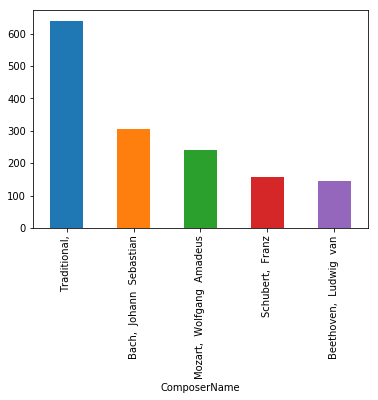

In [35]:
no_intervals = works['Interval'].isnull()
df_no_intervals = filter(works, no_intervals)

df_work_related = select(df_no_intervals, work_related_columns)

(df_work_related.groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
                .drop(columns='Movement')
                .drop_duplicates()
                .groupby('ComposerName').size()
                .nlargest()
                .plot(kind='bar'));

Code flows from top to bottom, and the function parameters are always near the function. 

Also, you eliminate an extra variable for each intermediate steps.

Now, explicitly naming things is good. Ideally you want to chain functions that make sense together and encapsulate them in an understandable blocks of logic.

In [36]:
def get_top_5_composers(df):
    df = df.copy()
    
    no_intervals = df['Interval'].isnull()
    df = filter(df, no_intervals)
    
    work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
    df = select(df, work_related_columns)
    
    df = (df.groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
            .drop(columns='Movement')
            .drop_duplicates()
            .groupby('ComposerName').size()
            .nlargest())
    return df

top_5_composers = get_top_5_composers(works)
top_5_composers

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

Another drawback to excessively long chains is that debugging is harder, as there no intermediate values to inspect.

**Segregate your code as to avoid long chains and keep only together what belongs together.**

(In case of doubt, read [The Zen of Python](https://www.python.org/dev/peps/pep-0020/) out loud 10 times.)

### 1.2.9 Custom methods and pipes

Now, for the final trick.

Both our functions `filter()` and `select()` have the exact signature we want, again:
* They receive a dataframe
* They return a dataframe.

What if Pandas had a way to include such functions in pipelines? Meet `df.pipe()`!

The method `df.pipe()` allows us to include user-defined functions in method chains (aka pipelines).

It works like this.

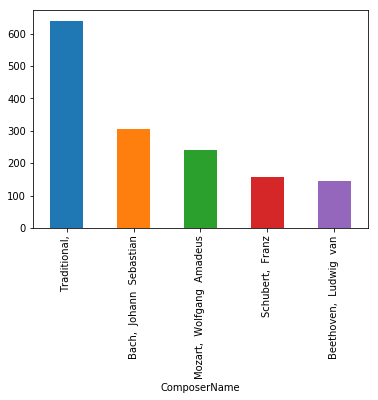

In [37]:
(df_work_related.pipe(filter, no_intervals)
                .pipe(select, work_related_columns)
                .groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
                .drop(columns='Movement')
                .drop_duplicates()
                .groupby('ComposerName').size()
                .nlargest()
                .plot(kind='bar'));

So, this should work.

In [38]:
def get_top_5_composers(df):
    no_intervals = df['Interval'].isnull()
    work_related_columns = ['ComposerName', 'WorkTitle', 'Movement']
    
    df = df.copy()
    df = (df.pipe(filter, no_intervals)
            .pipe(select, work_related_columns)
            .groupby('ComposerName').filter(lambda x: x.shape[0] > 10)
            .drop(columns='Movement')
            .drop_duplicates()
            .groupby('ComposerName').size()
            .nlargest())
    
    return df

top_5_composers = get_top_5_composers(works)
top_5_composers

ComposerName
Traditional,                  640
Bach,  Johann  Sebastian      306
Mozart,  Wolfgang  Amadeus    242
Schubert,  Franz              158
Beethoven,  Ludwig  van       144
dtype: int64

And it does!

Now, we have all the tools we need to build robust data transformation pipelines in Pandas.

In the next Notebook you will learn how to combine dataframes.